In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import yfinance as yf

In [2]:
# data = yf.download('TSLA', start='2006-05-23', end='2023-05-31',interval='1d')
# data['Closing']=data['Close']
# data.drop('Close',axis=1,inplace=True)
full = pd.read_csv('Train.csv')
data= full.head(150)
cols = list(data)[2:12]
data = data[cols].astype(float)

In [3]:
scaler = StandardScaler()
scaler = scaler.fit(data)
data_scaled = scaler.transform(data)
train_size=int(len(data_scaled)*0.8)
test_size = len(data_scaled)-train_size
train_scaled,test_scaled = data_scaled[:train_size],data_scaled[train_size:len(data_scaled)]
train_data,test_data = data[:train_size],data[train_size:len(data)]



In [4]:
def to_sequences(df_for_training_scaled,df_for_training,n_past,n_future=1):
    trainx=[]
    trainy=[]
    for i in range(n_past, len(df_for_training_scaled) - n_future +1):
        trainx.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
        trainy.append(df_for_training_scaled[i + n_future - 1:i + n_future, -1])

    trainx, trainy = np.array(trainx), np.array(trainy)
    return trainx,trainy

print('trainX shape == {}.'.format(to_sequences(train_scaled,train_data,14)[0].shape))
print('trainY shape == {}.'.format(to_sequences(train_scaled,train_data,14)[1].shape))




trainX shape == (106, 14, 10).
trainY shape == (106, 1).


In [5]:
trainX,trainY = to_sequences(train_scaled,train_data,14)
testX,testY = to_sequences(test_scaled,test_data,14)


In [6]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(64, activation='tanh', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True)) 
model.add(tf.keras.layers.LSTM(64, activation='relu', return_sequences=False))

model.add(tf.keras.layers.Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            19200     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 52,289
Trainable params: 52,289
Non-trainable params: 0
_________________________________________________________________


In [7]:

history = model.fit(trainX, trainY, epochs=5,batch_size=3, validation_split=0.2, verbose=1)


Epoch 1/5
28/28 [==============================] - 9s 99ms/step - loss: 0.3926 - val_loss: 0.0816
Epoch 2/5
28/28 [==============================] - 1s 23ms/step - loss: 0.0948 - val_loss: 0.0616
Epoch 3/5
28/28 [==============================] - 0s 16ms/step - loss: 0.0278 - val_loss: 0.0809
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 0.0173 - val_loss: 0.0749
Epoch 5/5
28/28 [==============================] - 1s 20ms/step - loss: 0.0161 - val_loss: 0.0595


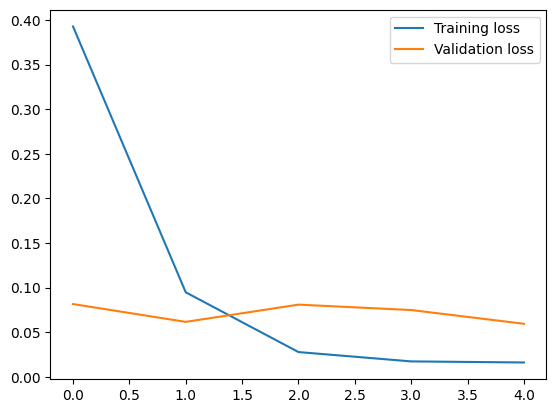

In [8]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

1/1 [==============================] - 2s 2s/step


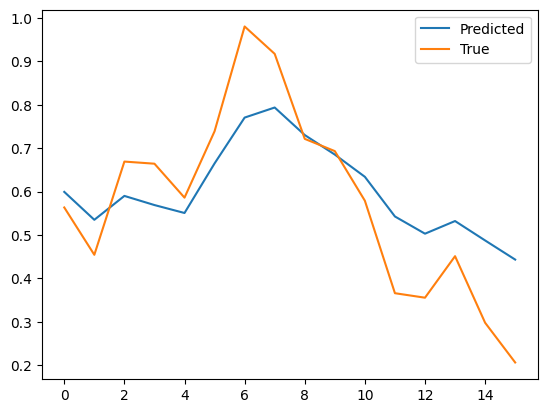

In [9]:
predictY = model.predict(testX)
plt.plot(predictY)
plt.plot(testY)
plt.legend(loc='best',labels=['Predicted','True'])

In [10]:

def directional_accuracy(y_true, y_pred):
    y_true_direction = np.sign(np.diff(y_true))
    y_pred_direction = np.sign(np.diff(y_pred))
    da = np.mean(y_true_direction == y_pred_direction)
    return da
def calculate_mae(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

def calculate_rmse(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    return rmse

def calculate_mape(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape


In [11]:
yo = testY.flatten()
oy = predictY.flatten()
print(f'directional_accuracy = {directional_accuracy(yo,oy)*100}%')
print(f'mae = {calculate_mae(yo,oy)}')
print(f'rmse = {calculate_rmse(yo,oy)}')
print(f'mape = {calculate_mape(yo,oy)}')



directional_accuracy = 93.33333333333333%
mae = 0.10240125594575705
rmse = 0.12357177658290901
mape = 24.996404870322568
